In [1]:
import pandas as pd
import numpy as np

In [3]:
!ls ./人脸关键点检测挑战赛_数据集/ -l

总用量 611464
-rw-rw-r-- 1 lyz lyz     49324 8月   5 16:54 sample_submit.csv
-rw-rw-r-- 1 lyz lyz 151068800 7月  31 18:11 test.npy
-rw-rw-r-- 1 lyz lyz  30636709 8月   5 16:57 test.npy.zip
-rw-rw-r-- 1 lyz lyz    577557 8月   5 16:54 train.csv
-rw-rw-r-- 1 lyz lyz 368640128 7月  31 18:11 train.npy
-rw-rw-r-- 1 lyz lyz  75144987 8月   5 16:57 train.npy.zip


In [86]:
train_df = pd.read_csv('人脸关键点检测挑战赛_数据集/train.csv')
train_df = train_df.fillna(48)
train_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.342364,38.523613,28.930840,35.577773,49.256845,68.275955,47.783946,85.361582
1,68.912604,31.409117,29.652226,33.028075,51.913358,48.408453,50.698868,79.574038
2,68.708994,40.371149,27.130820,40.940680,44.502523,69.988486,45.926427,86.221009
3,65.334176,35.471878,29.366461,37.767684,50.411373,64.934767,50.028780,74.883241
4,68.634857,29.999486,31.094571,29.616429,50.247429,51.450857,47.948571,84.394286


In [87]:
train_img = np.load('人脸关键点检测挑战赛_数据集/train.npy')
test_img = np.load('人脸关键点检测挑战赛_数据集/test.npy')

print(train_img.shape, test_img.shape)

(96, 96, 5000) (96, 96, 2049)


Populating the interactive namespace from numpy and matplotlib


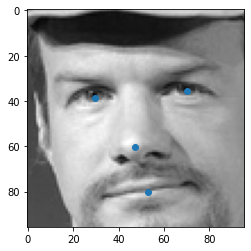

In [88]:
%pylab inline
idx = 409
xy = train_df.iloc[idx].values.reshape(-1, 2)
plt.scatter(xy[:, 0], xy[:, 1])
plt.imshow(train_img[:, :, idx], cmap='gray')

Populating the interactive namespace from numpy and matplotlib


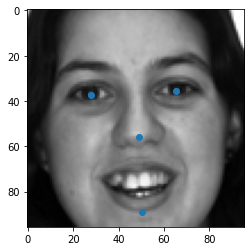

In [89]:
%pylab inline
idx = 400
xy = train_df.iloc[idx].values.reshape(-1, 2)
plt.scatter(xy[:, 0], xy[:, 1])
plt.imshow(train_img[:, :, idx], cmap='gray')

In [90]:
import os, sys, codecs, glob
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = False
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [91]:
class XunFeiDataset(Dataset):
    def __init__(self, img, keypoint, transform=None):
        self.img = img
        self.transform = transform
        self.keypoint = keypoint

    def __getitem__(self, index):
        img = Image.fromarray(self.img[:, :, index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, self.keypoint[index] / 96.0

    def __len__(self):
        return self.img.shape[-1]

In [92]:
train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_img[:, :, :-500], train_df.values[:-500],
                    transforms.Compose([
                        transforms.ToTensor(),
        ])
    ),
    batch_size=10, shuffle=True, num_workers=5,
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_img[:, :, -500:], train_df.values[-500:],
                    transforms.Compose([
                        transforms.ToTensor(),
        ])
    ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [93]:
train_img[:, :, -500:].shape

(96, 96, 500)

In [94]:
import timm

class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
        self.model = timm.create_model('efficientnet_b2', num_classes=8, 
                          pretrained=True)
        
    def forward(self, img, labels=None):        
        feat = self.model(img)
        return feat
    
model = XunFeiNet().cuda()

In [97]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True).float()
        target = target.cuda(non_blocking=True).float()

        output = model(input, target)
        loss = criterion(output, target)
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
        
        if i % 40 == 0:
            print(loss.item())
            
def validate(val_loader, model):
    model.eval()
    
    val_feats = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda().float()
            target = target.cuda().float()
            output = model(input)
            val_feats.append(output.data.cpu().numpy())
    return val_feats

In [108]:
from sklearn.metrics import mean_absolute_error

criterion = nn.MSELoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), 0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.85)
best_acc = 0.0

for epoch in range(20):
    print('Epoch: ', epoch)

    train(train_loader, model, criterion, optimizer, epoch)
    
    val_feats = validate(val_loader, model)
    scheduler.step()
    
    val_feats = np.vstack(val_feats) * 96 + 48
    print('Val', mean_absolute_error(val_feats, train_df.values[-500:]))

Epoch:  0
0.14932881295681
0.11036612093448639
0.1012566015124321
0.076789990067482
0.08345494419336319
0.08900832384824753
0.09732230752706528
0.05284625291824341
0.06075301393866539
0.06667089462280273
0.06253930926322937
0.047588419169187546
Val 21.679407207277357
Epoch:  1
0.06721837818622589
0.03572618588805199
0.03186364844441414
0.040276676416397095
0.03900137543678284
0.048599280416965485
0.026183605194091797
0.039958175271749496
0.03507665917277336
0.03169254586100578
0.0353345088660717
0.031176066026091576
Val 16.717350484993947
Epoch:  2
0.029041999951004982
0.02885553240776062
0.019698794931173325
0.03400104492902756
0.02097838930785656
0.035465043038129807
0.030916571617126465
0.03679990395903587
0.021085580810904503
0.025437980890274048
0.02623896673321724
0.020391065627336502
Val 14.216371347548904
Epoch:  3
0.02657110057771206
0.020630603656172752
0.018363019451498985
0.033554740250110626
0.019173502922058105
0.030652305111289024
0.020343098789453506
0.01951799914240837

KeyboardInterrupt: 

In [111]:
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_img, np.zeros((2049, 8)),
                    transforms.Compose([
                        transforms.ToTensor(),
        ])
    ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [112]:
pred_tta = []
for tti in range(1):
    pred = []
    with torch.no_grad():
        for t, (x, y) in enumerate(test_loader):
            x_var = Variable(x).cuda(async=True)
            y_var = Variable(y).cuda()
            scores = model(x_var)
            pred.append(scores.data.cpu().numpy())
    pred = np.concatenate(pred, 0)    
    print(tti)
    pred_tta.append(pred)

pred = np.mean(pred_tta, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  


0


In [121]:
col = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
 'right_eye_center_y', 'nose_tip_x', 'nose_tip_y', 
 'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y']
pd.DataFrame(pred * 96 + 48, columns=col).to_csv('submit.csv', index=None)

In [120]:
train_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.342364,38.523613,28.930840,35.577773,49.256845,68.275955,47.783946,85.361582
1,68.912604,31.409117,29.652226,33.028075,51.913358,48.408453,50.698868,79.574038
2,68.708994,40.371149,27.130820,40.940680,44.502523,69.988486,45.926427,86.221009
3,65.334176,35.471878,29.366461,37.767684,50.411373,64.934767,50.028780,74.883241
4,68.634857,29.999486,31.094571,29.616429,50.247429,51.450857,47.948571,84.394286
...,...,...,...,...,...,...,...,...
4995,66.489689,36.358727,28.595587,39.653849,45.071286,64.367420,45.071286,70.957708
4996,50.262958,43.791096,21.053248,39.981146,23.275707,59.348474,21.688240,70.778347
4997,67.068343,41.353426,31.536000,35.159712,51.747154,64.824329,48.161280,80.471602
4998,62.549189,41.343645,35.927611,43.211831,48.070832,60.025401,49.004886,67.965146
